<h1><center>MNIST classification using Numpy<center></h1>

## Importing Numpy and Keras

In [3]:
import numpy as np
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 1.10.0
Using keras version 2.2.2


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

In [4]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
(x_train, y_train),(x_test, y_test) =mnist.load_data(path="mnist.npz")



# START CODE HERE
print("Training set:")
print("    taille de x_train:",np.shape(x_train))
print("    taille de y_train:",np.shape(y_train))
print('\nTesting set:')
print("    taille de x_test:",np.shape(x_test))
print("    taille de y_test:",np.shape(y_test))
# END CODE HERE


Training set:
    taille de x_train: (60000, 28, 28)
    taille de y_train: (60000,)

Testing set:
    taille de x_test: (10000, 28, 28)
    taille de y_test: (10000,)


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

In [5]:
# Let us visualize the first training sample using the Matplotlib library
from matplotlib import pyplot as plt

# START CODE HERE
fig, axes = plt.subplots(3, 3, figsize=(15,8))
for i in range(9):
    ax = axes[i//3, i%3]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title("image n°"+str(i+1))
plt.tight_layout()
plt.show()
# END CODE HERE

<Figure size 1500x800 with 9 Axes>

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

In [6]:
from keras.utils.np_utils import to_categorical

y_train_simple = np.copy(y_train)
y_test_simple = np.copy(y_test)

# START CODE HERE
boolean = True
if boolean:
    y_train, y_test = to_categorical(y_train),to_categorical(y_test)
    boolean = False
y_train
# END CODE HERE

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

In [29]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = x_train.shape[1], x_train.shape[2]

# START CODE HERE
train_images = x_train.reshape(60000,-1)
test_images = x_test.reshape(10000,-1)
print("The new shape of the image is: ",np.shape(train_images))
print("The new shape of the image is: ",np.shape(test_images))

# END CODE HERE

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

print("\nNew mean of the train_image: ",np.mean(train_images))
print("New std of the train_image: ",np.std(train_images))

print("\nNew mean of the test_image: ",np.mean(test_images))
print("New std of the test_image: ",np.std(test_images))
# END CODE HERE

The new shape of the image is:  (60000, 784)
The new shape of the image is:  (10000, 784)

New mean of the train_image:  -1.7174248e-09
New std of the train_image:  0.95633847

New mean of the test_image:  0.0024957662
New std of the test_image:  0.9571717


# Working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

## Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.

In [19]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    # START CODE HERE
    W = np.random.normal(size = (n_input,n_output))
    b = np.zeros(n_output)
    nb_params = np.shape(W)[0]*np.shape(W)[1]+np.shape(b)[0]
    # END CODE HERE
    return W, b, nb_params

In [20]:
n_training = train_images.shape[0] 
n_feature = len(train_images[0])
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

In [21]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    z = X@W + b
    return z

## Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 

In [22]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    # We can use the following trick: using z-max(zi) instead of simpply z. The output will be unchanged.
    a = np.exp(z-np.max(z))
    out = a/np.sum(a)
    return out

## Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

In [23]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    grad_w = X.reshape((-1,1)) @ grad.reshape((-1,1)).T
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function:

In [24]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        return param-eta*grad_param
    elif regularizer=='L2':
        return (1 - 2*weight_decay)*param - eta*grad_param
    else:
        raise NotImplementedError

## Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.

In [25]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    ### Forward propagation
    z = forward(W,b,X)
    
    ### Compute the softmax and the prediction
    out = softmax(z)
    
    pred = np.argmax(z,axis=1)
    labels = np.argmax(labels,axis=1)
    
    ### Compute the accuracy
    accuracy = np.mean([pred==labels])
      
    return accuracy

## Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each trainin example once. 

In [26]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

In [27]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

W,b,nb = initLayer(784,10)

#######################
### Learning process ##
#######################
n_training = len(train_images)
for j in range(n_training):
    ### Getting the example
    X, y = train_images[j],y_train[j]

    ### Forward propagation
    z = forward(W,b,X)

    ### Compute the softmax
    out = softmax(z)
        
    ### Compute the gradient at the top layer
    derror = out - y # This is o - y 

    ### Update the parameters
    Wcopy = np.copy(W)
    W, b = update(eta, Wcopy, b, derror, X, regularizer, weight_decay)


    if j % log_interval == 0:
        ### Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, y_train) 

        ### And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, y_test) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = str(int(j)) + "      On train: " + str(train_accuracy) + "    On test:" + str(test_accuracy) + "    Eta:" + str(eta)
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + "    On train:" + str(train_accuracy) + "    On test:" + str(test_accuracy) + "    Eta:" + str(eta)
print(result_line)     

0      On train: 0.07193333333333334    On test:0.0651    Eta:0.01
5000      On train: 0.8230833333333333    On test:0.8239    Eta:0.01
10000      On train: 0.8584    On test:0.8594    Eta:0.01
15000      On train: 0.8431166666666666    On test:0.8412    Eta:0.01
20000      On train: 0.8399    On test:0.8477    Eta:0.01
25000      On train: 0.8484    On test:0.8532    Eta:0.01
30000      On train: 0.8509    On test:0.8528    Eta:0.01
35000      On train: 0.83895    On test:0.841    Eta:0.01
40000      On train: 0.852    On test:0.8521    Eta:0.01
45000      On train: 0.8551    On test:0.8555    Eta:0.01
50000      On train: 0.8495833333333334    On test:0.8552    Eta:0.01
55000      On train: 0.8299833333333333    On test:0.8329    Eta:0.01
Final result:    On train:0.8299833333333333    On test:0.8329    Eta:0.01


## Plotting the results

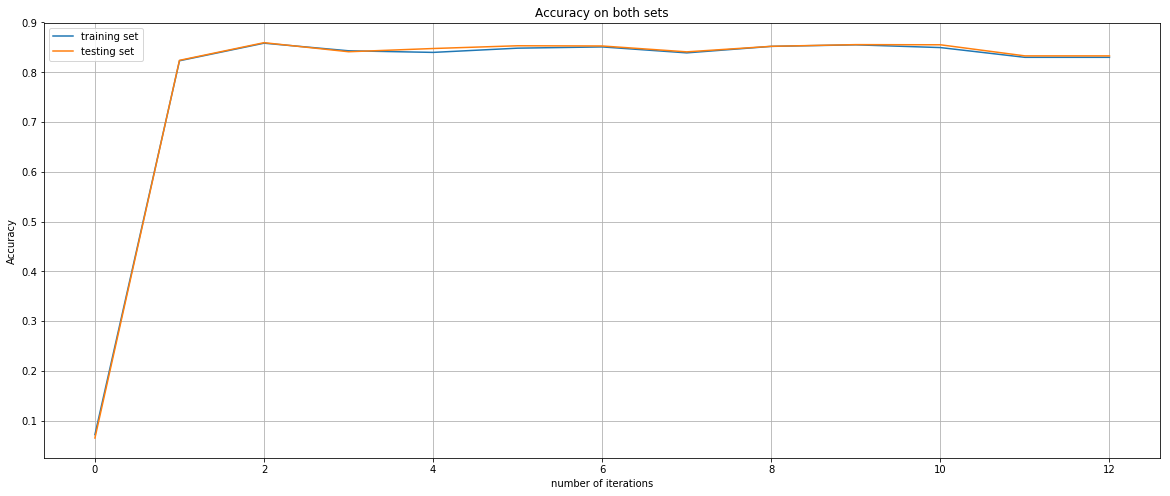

In [28]:
plt.figure(figsize=(20,8))
plt.title('Accuracy on both sets')
plt.grid()
plt.plot(g_train_acc,label='training set')
plt.plot(g_valid_acc,label='testing set')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('Accuracy')
plt.show()

## What can you say about the performance of this simple linear classifier ? 

###### Performance is very very good wit this simple linear classifier as the latter results show it.